# ELL729 Coding Assignment 1

Implementing Backwards Induction on a Finite State, Finite Action Markov Decision Process

In [6]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

# Some lines to print the rows of the output matrices in a single line, uncomment to use

# np.set_printoptions(edgeitems=30, linewidth=100000, 
    # formatter=dict(float=lambda x: "%.3g" % x))

In [2]:
# J is the matrix that stores the costs per day for every possible initial cost on every day
# 11 rows represent each one of the possible initial productivities before applying controls, from 0.0 to 1.0 in increments of 0.1
# 51 columns represent the total cost for each of the 50 days. The last column is a dummy column with all values 0 for the cost after termination
# t_optimal and w_optimal denote the optimal controls chosen at each day for each initial productivity value. 
# next_alpha stores the next value of alpha that is obtained when the optimal controls are applied at each step. We can use this table to
# obtain the sequence of states starting from any state at any time.s

# J is initialized with negative infinity values to ensure any value of revenue is stored. With certain values of the input parameters,
# it is not possible to secure positive revenue, rather one has to minimize the losses which is equivalent to maximizing revenue except that
# the maximal value is negative. The negative infinity initialisation accounts for this as well.

J = -np.inf*np.ones((11,51), dtype=float)
t_optimal = np.zeros((11,51), dtype = int)
w_optimal = np.zeros((11,51), dtype = int)
next_alpha = np.zeros((11,51), dtype = float)

for i in range(11):
    J[i][50] = 0

# The t and w vectors store all the possible values of controls for temperature and heavy water units from -5 to 5

t = np.zeros(11, dtype=int)
w = np.zeros(11, dtype=int)

# The a vector stores all the possible values of alpha (productivity) from 0.0 to 1.0, however it is stored as 0 to 10 and divided to get
# The range 0.0 to 1.0 when calculations are required

a = np.zeros(11, dtype = int) 

# The e vector stores the values of disturbance in the next state/productivity computation. It stores the values -0.05, 0 and 0.05

e = np.zeros(3, dtype = float)

In [3]:
# The following lines accept the input parameters from command line and store them in appropriately named variables
# c_t and c_w denote the cost of per unit increase in temperature and heavy water respectively
# M denotes the revenue generated from maximum productivity
# lamb denotes lambda, the cost per 0.1 deviation of the optimal productivity 0.3

c_t = 5 # float(sys.argv[1])
c_w = 5 # float(sys.argv[2])
M = 100 # float(sys.argv[3])
lamb = 20 # float(sys.argv[4])



In [4]:
# Initialisations for different vectors listed above

for i in range(11):
    t[i] = i-5
    w[i] = i-5
    a[i] = i

e[0] = -0.05
e[1] = 0
e[2] = 0.05

# validate_iter is a function that reins in the value of productivity if it exceeds the given range

def validate_iter(a):
    if(a < 0):
        a = 0
    if(a > 1):
        a = 1
    return a

# next_iter calculates the present day's productivity taking as input the initial productivity, the tuple (tk, wk) and disturbance epsilon
# The function uses the function described in the assignment specification. It also calls round_half_down and validate_iter when needed to
# perform rounding and reining in of alpha values when required


def next_iter(current_iter, control_tuple, eps):
    t = control_tuple[0]
    w = control_tuple[1]
    a_next = 0
    if(t >= 0 and w >= 0):
        a_next = round_half_down(current_iter + t*w/125 +eps)
        return validate_iter(a_next)
    elif(t < 0 and w < 0):
        a_next = round_half_down(current_iter - t*w/125 +eps)
        return validate_iter(a_next)
    else:
        a_next = round_half_down(current_iter - abs(t-w)/125 +eps)
        return validate_iter(a_next)

# round_half_down implements rounding of alpha values according to the rule specified in the assignment

def round_half_down(val):
    val = 10*val
    if(val - int(val) > 0.5):
        return (int(val) + 1)/10
    else:
        return (int(val))/10

# revenue calculates the per-day revenue using the formula revenue = profits - cost.
# The inputs are the present day productivity, the control tuple used on the day, and the four input parameters

def revenue(a, control_tuple, eps, t_cost, w_cost, full_efficiency, lamb):
    return a*full_efficiency - t_cost*max(0, control_tuple[0]) - w_cost*max(0, control_tuple[1]) - lamb*abs(a - 0.3)

# The following nested loop uses dynamic programming (uses precomputed values) and computes and stores the highest revenue starting 
# from each day or every initial productivity value. 
# It computes the per-day costs backwards, starting from day 50 to back to day 1. 
# For each day, every combination of controls is looped over along with every possible initial productivity value. 
# For each possible initial productivity value, the total cost is calculated by the sum of the current cost + the optimal cost if the
# initial productivity the next day is the present day productivity (calculated before hand as iterating over the days in backwards direction)
# Expected revenue is calculated and if it exceeds the value stored for that value and on that day, the value is updated
# and the optimal control pair is stored in t_optimal and w_optimal for temperature control and heavy water control respectively
# whenever the expected revenue is improved

for k in reversed(range(50)):
    for t_k in t:
        for w_k in w:
            for a_prev in a:
                E = 0
                for eps in e:
                    a_next = next_iter(a_prev/10,(t_k,w_k),eps)
                    E = E + revenue(a_next, (t_k,w_k), eps, c_t, c_w, M, lamb) + J[int(a_next*10)][k+1]
                E = E/3
                if(J[a_prev][k] < E):
                    next_alpha[a_prev][k] = a_next
                    J[a_prev][k] = round(E,2)
                    t_optimal[a_prev][k] = t_k
                    w_optimal[a_prev][k] = w_k

# Print statements which print the maximum revenue matrix, optimal temperature control, optimal heavy water controls and next
# productivity state on choosing the optimal controls in a state. The row/column pair indicates the starting productivity at the day 
# denoted by the index. A pair (r,c) indicates r/10 productivity to start the (c+1)th day.
# One extra column of zeros in the end which are to be ignored, they are present to indicate that nothing happens after the 
# last control is chosen.

print(J)
print()
print(t_optimal)
print()
print(w_optimal)
print()
print(next_alpha)
print()

[[3480.01 3403.01 3326.01 3249.01 3172.01 3095.01 3018.01 2941.01 2864.01
  2787.01 2710.01 2633.01 2556.01 2479.01 2402.01 2325.01 2248.01 2171.01
  2094.01 2017.01 1940.01 1863.01 1786.01 1709.01 1632.01 1555.01 1478.01
  1401.01 1324.01 1247.01 1170.01 1093.01 1016.01  939.01  862.01  785.01
   708.01  631.01  554.01  477.    400.    323.05  246.94  174.94  112.71
    70.     32.      4.    -12.     -6.      0.  ]
 [3546.84 3469.84 3392.84 3315.84 3238.84 3161.84 3084.84 3007.84 2930.84
  2853.84 2776.84 2699.84 2622.84 2545.84 2468.84 2391.84 2314.84 2237.84
  2160.84 2083.84 2006.84 1929.84 1852.84 1775.84 1698.84 1621.84 1544.84
  1467.84 1390.84 1313.84 1236.84 1159.84 1082.84 1005.84  928.84  851.84
   774.84  697.84  620.84  543.84  466.83  389.85  313.12  238.55  170.69
   116.38   76.07   43.11   12.67    6.      0.  ]
 [3589.01 3512.01 3435.01 3358.01 3281.01 3204.01 3127.01 3050.01 2973.01
  2896.01 2819.01 2742.01 2665.01 2588.01 2511.01 2434.01 2357.01 2280.01
  2203.01 

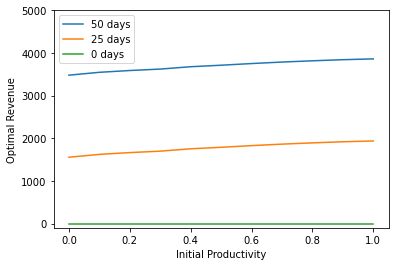

In [24]:
J_zero = np.zeros(J.shape[0])
J_25 = np.zeros(J.shape[0])
J_50 = np.zeros(J.shape[0])

for i in range(J.shape[0]):
    J_zero[i] = J[i,0]
    J_25[i] = J[i,25]
    J_50[i] = J[i,50]

plt.plot(np.linspace(0,10,11)/10,J_zero,label = '50 days')
plt.plot(np.linspace(0,10,11)/10,J_25,label = '25 days')
plt.plot(np.linspace(0,10,11)/10,J_50,label = '0 days')
plt.xlabel('Initial Productivity')
plt.ylabel('Optimal Revenue')
ax = plt.gca()
ax.set_ylim(bottom = -100, top = 5000)
# plt.plot(np.linspace(0,50,51),J[10],label = 'Backwards induction for state 0')
plt.legend()
plt.show()